In [1]:
import math
import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

seed = 1994

train = pd.read_csv('../input/train.csv', na_values=-1)
test = pd.read_csv('../input/test.csv', na_values=-1)

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Add a new feature: interaction term ps_car_13 * ps_reg_03
train['ps_car_13_X_ps_reg_03'] = train['ps_car_13'] * train['ps_reg_03']
test['ps_car_13_X_ps_reg_03'] = test['ps_car_13'] * test['ps_reg_03']

# Add a new feature: number of NA's per ID
train['n_missing_per_row'] = train.isnull().sum(axis=1)
test['n_missing_per_row'] = test.isnull().sum(axis=1)

# add a new feature: number of binary features per ID
binary_columns = train.columns[train.columns.str.startswith('ps_ind') & \
                               train.columns.str.endswith('_bin')].values
train['n_binary_per_row'] = train[binary_columns].sum(axis=1)
test['n_binary_per_row'] = test[binary_columns].sum(axis=1)

# Add a new feature: difference measure for binary features, the reference row is the median
binary_columns = train.columns[train.columns.str.startswith('ps_ind') & \
                               train.columns.str.endswith('_bin')].values
train['diff_bin'] = np.absolute( \
                                train[binary_columns] - train[binary_columns].median() \
                               ).sum(axis=1).astype(np.int)
test['diff_bin'] = np.absolute( \
                               test[binary_columns] - train[binary_columns].median() \
                              ).sum(axis=1).astype(np.int)

# Add a new feature: difference measure for calc binary features, the reference is median
calc_bin_columns = train.columns[train.columns.str.startswith('ps_calc') & \
                                 train.columns.str.endswith('_bin')].values
train['diff_calc_bin'] = np.absolute( \
                                     train[calc_bin_columns] - train[calc_bin_columns].median() \
                                    ).sum(axis=1).astype(np.int)
test['diff_calc_bin'] = np.absolute( \
                                    test[calc_bin_columns] - train[calc_bin_columns].median() \
                                   ).sum(axis=1).astype(np.int)

# Add a new feature: number of calc binary features per ID
train['n_calc_bin_per_row'] = train[calc_bin_columns].sum(axis=1)
test['n_calc_bin_per_row'] = test[calc_bin_columns].sum(axis=1)

# Drop calc features, which are not significant for this dataset
calc_columns = train.columns[train.columns.str.startswith('ps_calc')].values
train.drop(calc_columns, axis=1, inplace=True)
test.drop(calc_columns, axis=1, inplace=True)

# Perform one-hot encoding on categorical features
categorical_columns = train.columns[train.columns.str.endswith('_cat')].values
train_test = pd.concat([train, test], ignore_index=True)
train_test = pd.get_dummies(train_test, columns=categorical_columns)

train = train_test[:train.shape[0]]
test = train_test[train.shape[0]:]
X_train, y_train = train.drop(['target', 'id'], axis=1), train['target']
X_test = test.drop(['target', 'id'], axis=1)

In [3]:
# Fix eta to 0.1 and tune the best num_boost_round (this gives 113)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.1,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': seed,
    'scale_pos_weight': 1
}

dtrain = xgb.DMatrix(data=X_train, label=y_train)
cv_result = xgb.cv(params=params, dtrain=dtrain, num_boost_round=1000, nfold=5, \
                   metrics='auc', early_stopping_rounds=50, stratified=True, verbose_eval=True)
cv_result.shape[0]

In [16]:
# Tune max_depth and min_child_weight, stepsize = 2 (this gives 5, 7 and AUC 0.6404096405252967)
param_grid1 = {
    'max_depth': [3, 5, 7, 9], 
    'min_child_weight': [1, 3, 5, 7, 9]
}

gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=113, \
                                                max_depth=5, min_child_weight=1, gamma=0, \
                                                subsample=0.8, colsample_bytree=0.8, \
                                                objective= 'binary:logistic', scale_pos_weight=1, seed=seed), \
                        param_grid=param_grid1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63718, std: 0.00191, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.63732, std: 0.00253, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.63701, std: 0.00224, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.63711, std: 0.00234, params: {'max_depth': 3, 'min_child_weight': 7},
  mean: 0.63708, std: 0.00208, params: {'max_depth': 3, 'min_child_weight': 9},
  mean: 0.63932, std: 0.00309, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.63977, std: 0.00302, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.63967, std: 0.00309, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.64041, std: 0.00293, params: {'max_depth': 5, 'min_child_weight': 7},
  mean: 0.63977, std: 0.00327, params: {'max_depth': 5, 'min_child_weight': 9},
  mean: 0.63686, std: 0.00315, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.63743, std: 0.00311, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.63730, std: 0.00340, params: {

In [17]:
# Tune max_depth and min_child_weight, stepsize deeper to 1 (this gives 5, 7 and AUC 0.6404096405252967)
param_grid2 = {
    'max_depth': [4, 5, 6], 
    'min_child_weight': [6, 7, 8]
}

gsearch2 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=113, \
                                                max_depth=5, min_child_weight=7, gamma=0, \
                                                subsample=0.8, colsample_bytree=0.8, scale_pos_weight=1, \
                                                objective= 'binary:logistic', nthread=4, seed=seed), \
                        param_grid=param_grid2, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch2.fit(X_train, y_train)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63937, std: 0.00218, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: 0.63921, std: 0.00246, params: {'max_depth': 4, 'min_child_weight': 7},
  mean: 0.63945, std: 0.00277, params: {'max_depth': 4, 'min_child_weight': 8},
  mean: 0.63994, std: 0.00348, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: 0.64041, std: 0.00293, params: {'max_depth': 5, 'min_child_weight': 7},
  mean: 0.64018, std: 0.00304, params: {'max_depth': 5, 'min_child_weight': 8},
  mean: 0.63935, std: 0.00289, params: {'max_depth': 6, 'min_child_weight': 6},
  mean: 0.64002, std: 0.00243, params: {'max_depth': 6, 'min_child_weight': 7},
  mean: 0.63957, std: 0.00252, params: {'max_depth': 6, 'min_child_weight': 8}],
 {'max_depth': 5, 'min_child_weight': 7},
 0.6404096405252967)

In [31]:
# Tune gamma (this gives 0, and AUC 0.6404096405252967)
param_grid3 = {
    'gamma': np.append(0, np.logspace(-3, 1, base=2, num=10))
}

gsearch3 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=113, \
                                                max_depth=5, min_child_weight=7, gamma=0, \
                                                subsample=0.8, colsample_bytree=0.8, scale_pos_weight=1, \
                                                objective= 'binary:logistic', nthread=4, seed=seed), \
                        param_grid=param_grid3, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch3.fit(X_train, y_train)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.64041, std: 0.00293, params: {'gamma': 0.0},
  mean: 0.64030, std: 0.00297, params: {'gamma': 0.125},
  mean: 0.64037, std: 0.00289, params: {'gamma': 0.17009875002179714},
  mean: 0.64038, std: 0.00289, params: {'gamma': 0.23146867807182259},
  mean: 0.64008, std: 0.00278, params: {'gamma': 0.3149802624737183},
  mean: 0.63990, std: 0.00301, params: {'gamma': 0.4286219914265364},
  mean: 0.63988, std: 0.00294, params: {'gamma': 0.58326451978805838},
  mean: 0.63985, std: 0.00279, params: {'gamma': 0.79370052598409968},
  mean: 0.64012, std: 0.00303, params: {'gamma': 1.0800597388923059},
  mean: 0.64013, std: 0.00290, params: {'gamma': 1.4697344922755986},
  mean: 0.63978, std: 0.00318, params: {'gamma': 2.0}],
 {'gamma': 0.0},
 0.6404096405252967)

In [35]:
# Re-tune num_boost_round for updated parameters (this gives 152)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.1,
    'max_depth': 5,
    'min_child_weight': 7,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': seed,
    'scale_pos_weight': 1
}

dtrain = xgb.DMatrix(data=X_train, label=y_train)
cv_result = xgb.cv(params=params, dtrain=dtrain, num_boost_round=1000, nfold=5, \
                   metrics='auc', early_stopping_rounds=50, stratified=True, verbose_eval=True)
cv_result.shape[0]

[0]	train-auc:0.608481+0.00345585	test-auc:0.60527+0.00698971
[1]	train-auc:0.616218+0.00319283	test-auc:0.61092+0.00617344
[2]	train-auc:0.620657+0.00176259	test-auc:0.615092+0.00756127
[3]	train-auc:0.622691+0.00165952	test-auc:0.616607+0.00752961
[4]	train-auc:0.625008+0.00153355	test-auc:0.618279+0.00754732
[5]	train-auc:0.626215+0.00209363	test-auc:0.619465+0.00679939
[6]	train-auc:0.626596+0.00144412	test-auc:0.620075+0.00711323
[7]	train-auc:0.627074+0.00160372	test-auc:0.620643+0.00718144
[8]	train-auc:0.627708+0.00143029	test-auc:0.621056+0.00745031
[9]	train-auc:0.628552+0.00114825	test-auc:0.621598+0.00803518
[10]	train-auc:0.628674+0.000834126	test-auc:0.621807+0.00839543
[11]	train-auc:0.629275+0.00117918	test-auc:0.622224+0.00807514
[12]	train-auc:0.62963+0.00123048	test-auc:0.622562+0.00778498
[13]	train-auc:0.630136+0.00139123	test-auc:0.622943+0.00782798
[14]	train-auc:0.630478+0.00161942	test-auc:0.623051+0.00773471
[15]	train-auc:0.630949+0.00180261	test-auc:0.623083

[129]	train-auc:0.682286+0.00131935	test-auc:0.640025+0.00594575
[130]	train-auc:0.682515+0.00141706	test-auc:0.640046+0.00595869
[131]	train-auc:0.682835+0.00148754	test-auc:0.640043+0.00594105
[132]	train-auc:0.683108+0.00150366	test-auc:0.640057+0.00585338
[133]	train-auc:0.683335+0.00147925	test-auc:0.640037+0.00588052
[134]	train-auc:0.683585+0.00147792	test-auc:0.640071+0.00589853
[135]	train-auc:0.683827+0.00151822	test-auc:0.640048+0.00595239
[136]	train-auc:0.68407+0.00145666	test-auc:0.640072+0.00596496
[137]	train-auc:0.684242+0.00145887	test-auc:0.640094+0.00598895
[138]	train-auc:0.684498+0.00146943	test-auc:0.640107+0.00595111
[139]	train-auc:0.684757+0.00141707	test-auc:0.640074+0.00597539
[140]	train-auc:0.684969+0.00134354	test-auc:0.640042+0.0059523
[141]	train-auc:0.685225+0.00130782	test-auc:0.640053+0.00588291
[142]	train-auc:0.685449+0.00131966	test-auc:0.640049+0.00588835
[143]	train-auc:0.685634+0.00135915	test-auc:0.64014+0.00588106
[144]	train-auc:0.685812+0.0

152

In [37]:
# Tune subsample, colsample_bytree (this gives 0.8, 0.8 and AUC 0.64046820986463759)
param_grid4 = {
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9]
}

gsearch4 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=152, \
                                                max_depth=5, min_child_weight=7, gamma=0, \
                                                subsample=0.8, colsample_bytree=0.8, scale_pos_weight=1, \
                                                objective= 'binary:logistic', nthread=4, seed=seed), \
                        param_grid=param_grid4, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch4.fit(X_train, y_train)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63791, std: 0.00273, params: {'colsample_bytree': 0.5, 'subsample': 0.5},
  mean: 0.63897, std: 0.00225, params: {'colsample_bytree': 0.5, 'subsample': 0.6},
  mean: 0.63893, std: 0.00255, params: {'colsample_bytree': 0.5, 'subsample': 0.7},
  mean: 0.63982, std: 0.00301, params: {'colsample_bytree': 0.5, 'subsample': 0.8},
  mean: 0.64004, std: 0.00211, params: {'colsample_bytree': 0.5, 'subsample': 0.9},
  mean: 0.63773, std: 0.00172, params: {'colsample_bytree': 0.6, 'subsample': 0.5},
  mean: 0.63950, std: 0.00287, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.63946, std: 0.00206, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.63919, std: 0.00253, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.63988, std: 0.00188, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.63823, std: 0.00172, params: {'colsample_bytree': 0.7, 'subsample': 0.5},
  mean: 0.63971, std: 0.00222, params: {'colsample_bytree': 0.7, 'subsample'

In [39]:
# Tune subsample and colsample_bytree, stepsize steeper to 0.05 (this gives 0.85, 0.75 and AUC 0.64050797821123662)
param_grid5 = {
    'subsample': [0.75, 0.8, 0.85],
    'colsample_bytree': [0.75, 0.8, 0.85]
}

gsearch5 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=152, \
                                                max_depth=5, min_child_weight=7, gamma=0, \
                                                subsample=0.8, colsample_bytree=0.8, scale_pos_weight=1, \
                                                objective= 'binary:logistic', nthread=4, seed=seed), \
                        param_grid=param_grid5, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch5.fit(X_train, y_train)
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63967, std: 0.00275, params: {'colsample_bytree': 0.75, 'subsample': 0.75},
  mean: 0.64031, std: 0.00276, params: {'colsample_bytree': 0.75, 'subsample': 0.8},
  mean: 0.64051, std: 0.00158, params: {'colsample_bytree': 0.75, 'subsample': 0.85},
  mean: 0.63955, std: 0.00269, params: {'colsample_bytree': 0.8, 'subsample': 0.75},
  mean: 0.64047, std: 0.00258, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.63986, std: 0.00246, params: {'colsample_bytree': 0.8, 'subsample': 0.85},
  mean: 0.64046, std: 0.00162, params: {'colsample_bytree': 0.85, 'subsample': 0.75},
  mean: 0.63976, std: 0.00313, params: {'colsample_bytree': 0.85, 'subsample': 0.8},
  mean: 0.64026, std: 0.00302, params: {'colsample_bytree': 0.85, 'subsample': 0.85}],
 {'colsample_bytree': 0.75, 'subsample': 0.85},
 0.64050797821123662)

In [42]:
# Tune alpha and lambda (this gives 10, 3 and AUC 0.64194790057456597, but too coincidence!!)
param_grid6 = {
    'reg_alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'reg_lambda': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

gsearch6 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=152, \
                                                max_depth=5, min_child_weight=7, gamma=0, \
                                                subsample=0.85, colsample_bytree=0.75, scale_pos_weight=1, \
                                                objective='binary:logistic', nthread=4, seed=seed), \
                        param_grid=param_grid6, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch6.fit(X_train, y_train)
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.64053, std: 0.00225, params: {'reg_alpha': 1, 'reg_lambda': 1},
  mean: 0.64053, std: 0.00273, params: {'reg_alpha': 1, 'reg_lambda': 2},
  mean: 0.64094, std: 0.00229, params: {'reg_alpha': 1, 'reg_lambda': 3},
  mean: 0.64086, std: 0.00241, params: {'reg_alpha': 1, 'reg_lambda': 4},
  mean: 0.64050, std: 0.00213, params: {'reg_alpha': 1, 'reg_lambda': 5},
  mean: 0.64111, std: 0.00185, params: {'reg_alpha': 1, 'reg_lambda': 6},
  mean: 0.64110, std: 0.00243, params: {'reg_alpha': 1, 'reg_lambda': 7},
  mean: 0.64086, std: 0.00248, params: {'reg_alpha': 1, 'reg_lambda': 8},
  mean: 0.64093, std: 0.00228, params: {'reg_alpha': 1, 'reg_lambda': 9},
  mean: 0.64153, std: 0.00279, params: {'reg_alpha': 1, 'reg_lambda': 10},
  mean: 0.64037, std: 0.00266, params: {'reg_alpha': 2, 'reg_lambda': 1},
  mean: 0.64059, std: 0.00231, params: {'reg_alpha': 2, 'reg_lambda': 2},
  mean: 0.64108, std: 0.00324, params: {'reg_alpha': 2, 'reg_lambda': 3},
  mean: 0.64090, std: 0.00249, params

In [43]:
# Tune alpha and lambda, with different range based on previous results (this gives 12, 3 and AUC 0.64176)
param_grid7 = {
    'reg_alpha': [10, 11, 12],
    'reg_lambda': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

gsearch7 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=152, \
                                                max_depth=5, min_child_weight=7, gamma=0, \
                                                subsample=0.85, colsample_bytree=0.75, scale_pos_weight=1, \
                                                objective='binary:logistic', nthread=4, seed=seed), \
                        param_grid=param_grid7, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch7.fit(X_train, y_train)
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.64137, std: 0.00275, params: {'reg_alpha': 10, 'reg_lambda': 1},
  mean: 0.64142, std: 0.00254, params: {'reg_alpha': 10, 'reg_lambda': 2},
  mean: 0.64195, std: 0.00277, params: {'reg_alpha': 10, 'reg_lambda': 3},
  mean: 0.64137, std: 0.00265, params: {'reg_alpha': 10, 'reg_lambda': 4},
  mean: 0.64159, std: 0.00290, params: {'reg_alpha': 10, 'reg_lambda': 5},
  mean: 0.64150, std: 0.00256, params: {'reg_alpha': 10, 'reg_lambda': 6},
  mean: 0.64151, std: 0.00256, params: {'reg_alpha': 10, 'reg_lambda': 7},
  mean: 0.64131, std: 0.00309, params: {'reg_alpha': 10, 'reg_lambda': 8},
  mean: 0.64139, std: 0.00281, params: {'reg_alpha': 10, 'reg_lambda': 9},
  mean: 0.64132, std: 0.00305, params: {'reg_alpha': 10, 'reg_lambda': 10},
  mean: 0.64161, std: 0.00265, params: {'reg_alpha': 11, 'reg_lambda': 1},
  mean: 0.64153, std: 0.00285, params: {'reg_alpha': 11, 'reg_lambda': 2},
  mean: 0.64134, std: 0.00263, params: {'reg_alpha': 11, 'reg_lambda': 3},
  mean: 0.64141, std: 0.

In [ ]:
# Tune alpha and lambda, with different range based on previous results (this gives 12, 3 and AUC 0.64176)
param_grid8 = {
    'reg_alpha': [13, 14],
    'reg_lambda': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

gsearch8 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=152, \
                                                max_depth=5, min_child_weight=7, gamma=0, \
                                                subsample=0.85, colsample_bytree=0.75, scale_pos_weight=1, \
                                                objective='binary:logistic', nthread=4, seed=seed), \
                        param_grid=param_grid8, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch8.fit(X_train, y_train)
gsearch8.cv_results_, gsearch8.best_params_, gsearch8.best_score_

In [110]:
# Tune alpha and lambda, with deeper stepsize (this gives 12.17891188084994, 3.6 and AUC 0.64197644888855376)
param_grid9 = {
    'reg_alpha': np.logspace(math.log2(11.2), math.log2(12.7), base=2, num=7),
    'reg_lambda': np.logspace(math.log2(2.1), math.log2(3.6), base=2, num=7)
}

gsearch9 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=152, \
                                                max_depth=5, min_child_weight=7, gamma=0, \
                                                subsample=0.85, colsample_bytree=0.75, scale_pos_weight=1, \
                                                objective='binary:logistic', nthread=4, seed=seed), \
                        param_grid=param_grid9, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch9.fit(X_train, y_train)
gsearch9.cv_results_, gsearch9.best_params_, gsearch9.best_score_

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.64154, std: 0.00281, params: {'reg_alpha': 11.199999999999998, 'reg_lambda': 2.1000000000000001},
  mean: 0.64157, std: 0.00315, params: {'reg_alpha': 11.199999999999998, 'reg_lambda': 2.297381726834101},
  mean: 0.64143, std: 0.00292, params: {'reg_alpha': 11.199999999999998, 'reg_lambda': 2.5133156184720167},
  mean: 0.64151, std: 0.00306, params: {'reg_alpha': 11.199999999999998, 'reg_lambda': 2.7495454169735041},
  mean: 0.64130, std: 0.00269, params: {'reg_alpha': 11.199999999999998, 'reg_lambda': 3.0079787609787503},
  mean: 0.64147, std: 0.00239, params: {'reg_alpha': 11.199999999999998, 'reg_lambda': 3.290702590560791},
  mean: 0.64152, std: 0.00280, params: {'reg_alpha': 11.199999999999998, 'reg_lambda': 3.6000000000000001},
  mean: 0.64157, std: 0.00302, params: {'reg_alpha': 11.43709264422173, 'reg_lambda': 2.1000000000000001},
  mean: 0.64150, std: 0.00267, params: {'reg_alpha': 11.43709264422173, 'reg_lambda': 2.297381726834101},
  mean: 0.64160, std: 0.00256, pa

In [113]:
# Reduce learning rate and tune num_boost_round again (this gives 0.01, 1851)
etas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08][::-1]
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 5,
    'min_child_weight': 7,
    'gamma': 0,
    'subsample': 0.85,
    'colsample_bytree': 0.75,
    'scale_pos_weight': 1,
    'alpha': 12.17891188084994,
    'lambda': 3.6,
    'seed': seed
}

res = pd.DataFrame(columns=['eta', 'test-auc-mean', 'test-auc-std', 'train-auc-mean', 'train-auc-std'])
for eta in etas:
    params['eta'] = eta
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    cv_result = xgb.cv(params=params, dtrain=dtrain, num_boost_round=5000, nfold=5, \
                       metrics='auc', early_stopping_rounds=50, stratified=True, verbose_eval=10)
    best_rounds = cv_result.shape[0]
    tmp = cv_result.iloc[best_rounds-1].to_frame().transpose()
    tmp['eta'] = eta
    res = pd.concat([res, tmp])
    print('********************************************************')
    print(res)

[0]	train-auc:0.567564+0.0016154	test-auc:0.567178+0.00561791
[10]	train-auc:0.60503+0.00225026	test-auc:0.602784+0.00833196
[20]	train-auc:0.617881+0.00208758	test-auc:0.613525+0.00634119
[30]	train-auc:0.626129+0.00174501	test-auc:0.619705+0.00687034
[40]	train-auc:0.633878+0.00168206	test-auc:0.625343+0.0067637
[50]	train-auc:0.640629+0.00149772	test-auc:0.630004+0.00694164
[60]	train-auc:0.646226+0.00153285	test-auc:0.633405+0.00648981
[70]	train-auc:0.650766+0.00127461	test-auc:0.635831+0.00642507
[80]	train-auc:0.654309+0.00113827	test-auc:0.637324+0.00629088
[90]	train-auc:0.657337+0.0010679	test-auc:0.638625+0.00613542
[100]	train-auc:0.660037+0.000991291	test-auc:0.639608+0.00614819
[110]	train-auc:0.662464+0.000909342	test-auc:0.640202+0.00617951
[120]	train-auc:0.664634+0.00109142	test-auc:0.640759+0.00605624
[130]	train-auc:0.666809+0.00113776	test-auc:0.641222+0.00594187
[140]	train-auc:0.668667+0.00112975	test-auc:0.64155+0.0059335
[150]	train-auc:0.670547+0.00113789	test

[230]	train-auc:0.669484+0.000868515	test-auc:0.641968+0.00573859
[240]	train-auc:0.67068+0.000852879	test-auc:0.642081+0.00567036
[250]	train-auc:0.671799+0.000738755	test-auc:0.642254+0.0056617
[260]	train-auc:0.672897+0.00077759	test-auc:0.642392+0.00564047
[270]	train-auc:0.673956+0.000695379	test-auc:0.642512+0.00559159
[280]	train-auc:0.674946+0.000704009	test-auc:0.642524+0.00559994
[290]	train-auc:0.676016+0.000794511	test-auc:0.642622+0.00563713
[300]	train-auc:0.676958+0.000846229	test-auc:0.642633+0.005619
[310]	train-auc:0.677891+0.000786437	test-auc:0.642644+0.0056158
[320]	train-auc:0.678801+0.000907496	test-auc:0.642677+0.00561045
[330]	train-auc:0.679875+0.000954979	test-auc:0.642704+0.00570876
[340]	train-auc:0.680756+0.000988312	test-auc:0.642748+0.00566096
[350]	train-auc:0.681712+0.000963095	test-auc:0.64279+0.005643
[360]	train-auc:0.682641+0.00100988	test-auc:0.642837+0.00569888
[370]	train-auc:0.683527+0.000993152	test-auc:0.642793+0.00567357
[380]	train-auc:0.68

[440]	train-auc:0.673329+0.00129034	test-auc:0.64273+0.00570733
[450]	train-auc:0.673983+0.00127038	test-auc:0.642783+0.00570664
[460]	train-auc:0.674627+0.00129997	test-auc:0.642848+0.00569082
[470]	train-auc:0.675274+0.00132332	test-auc:0.64293+0.00567854
[480]	train-auc:0.675836+0.00130797	test-auc:0.643015+0.00563699
[490]	train-auc:0.676444+0.00129247	test-auc:0.643047+0.00564204
[500]	train-auc:0.677073+0.00131314	test-auc:0.643081+0.00556675
[510]	train-auc:0.677683+0.00125475	test-auc:0.643121+0.00554517
[520]	train-auc:0.678209+0.00126462	test-auc:0.643137+0.00550582
[530]	train-auc:0.678798+0.00129572	test-auc:0.643132+0.00548647
[540]	train-auc:0.679399+0.0012924	test-auc:0.64313+0.00548122
[550]	train-auc:0.679946+0.00127675	test-auc:0.643157+0.00545737
[560]	train-auc:0.68057+0.00126155	test-auc:0.643184+0.00543655
[570]	train-auc:0.681171+0.00133095	test-auc:0.643231+0.00541892
[580]	train-auc:0.681742+0.00131407	test-auc:0.643248+0.00537329
[590]	train-auc:0.682274+0.001

[910]	train-auc:0.683451+0.00114514	test-auc:0.643357+0.00574465
[920]	train-auc:0.683806+0.00115569	test-auc:0.643361+0.00575001
[930]	train-auc:0.684175+0.00115526	test-auc:0.64339+0.00574868
[940]	train-auc:0.684531+0.00114402	test-auc:0.643412+0.00572056
[950]	train-auc:0.684909+0.00114229	test-auc:0.643429+0.00572664
[960]	train-auc:0.685253+0.00112613	test-auc:0.64343+0.00574136
[970]	train-auc:0.685618+0.00111315	test-auc:0.64344+0.00573841
[980]	train-auc:0.685969+0.00111307	test-auc:0.643447+0.00571285
[990]	train-auc:0.686308+0.0011064	test-auc:0.643449+0.00570041
[1000]	train-auc:0.68665+0.00112264	test-auc:0.643437+0.00569536
[1010]	train-auc:0.687003+0.001102	test-auc:0.643402+0.00569259
[1020]	train-auc:0.687351+0.00106934	test-auc:0.643365+0.00568733
[1030]	train-auc:0.687754+0.00106682	test-auc:0.643332+0.00568901
[1040]	train-auc:0.688113+0.00103939	test-auc:0.643314+0.0056678
********************************************************
      eta  test-auc-mean  test-auc-s

[1040]	train-auc:0.66703+0.000925586	test-auc:0.641869+0.00583992
[1050]	train-auc:0.667294+0.000943301	test-auc:0.641932+0.0058341
[1060]	train-auc:0.667542+0.000943944	test-auc:0.64198+0.00583142
[1070]	train-auc:0.66778+0.000946483	test-auc:0.642015+0.00582859
[1080]	train-auc:0.668015+0.000946571	test-auc:0.642061+0.00581879
[1090]	train-auc:0.668267+0.000945677	test-auc:0.642122+0.00580618
[1100]	train-auc:0.668524+0.000955813	test-auc:0.642168+0.00580144
[1110]	train-auc:0.668775+0.000946739	test-auc:0.64222+0.00578175
[1120]	train-auc:0.669015+0.000950016	test-auc:0.642262+0.00577169
[1130]	train-auc:0.669233+0.000961333	test-auc:0.642292+0.00576696
[1140]	train-auc:0.669463+0.000957171	test-auc:0.642308+0.0057582
[1150]	train-auc:0.669714+0.000943498	test-auc:0.642383+0.0057704
[1160]	train-auc:0.669955+0.0009486	test-auc:0.642405+0.00576503
[1170]	train-auc:0.670208+0.000948945	test-auc:0.642436+0.00577158
[1180]	train-auc:0.67045+0.000935847	test-auc:0.642486+0.00576473
[1190

In [114]:
best_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.01,
    'max_depth': 5,
    'min_child_weight': 7,
    'gamma': 0,
    'subsample': 0.85,
    'colsample_bytree': 0.75,
    'scale_pos_weight': 1,
    'alpha': 12.17891188084994,
    'lambda': 3.6,
    'seed': seed
}
best_rounds = 1851

In [117]:
# Cross-validation to validate the performance for best parameters
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)
prob_train = np.array([0.0 for _ in range(train.shape[0])])

X, y = X_train.values, y_train.values
for idx_train, idx_validation in skf.split(X, y):
    X_train_cv, X_validation_cv = X[idx_train], X[idx_validation]
    y_train_cv, y_validation_cv = y[idx_train], y[idx_validation]
    
    dtrain = xgb.DMatrix(data=X_train_cv, label=y_train_cv)
    dvalidation = xgb.DMatrix(data=X_validation_cv, label=y_validation_cv)
    
    model = xgb.train(params=best_params, dtrain=dtrain, num_boost_round=best_rounds)
    prob_trn = model.predict(dtrain, ntree_limit=best_rounds)
    prob_val = model.predict(dvalidation, ntree_limit=best_rounds)
    prob_train[idx_validation] += prob_val
    print('Gini on CV training set:', metrics.gini_normalized(y_train_cv, prob_trn))
    print('Gini on CV validation set:', metrics.gini_normalized(y_validation_cv, prob_val))
    print('************************************************************')
print('Gini on training set:', metrics.gini_normalized(y, prob_train))

Gini on CV training set: 0.36608603759
Gini on CV validation set: 0.298554334234
************************************************************
Gini on CV training set: 0.370268484879
Gini on CV validation set: 0.280623994195
************************************************************
Gini on CV training set: 0.369021879727
Gini on CV validation set: 0.287609417979
************************************************************
Gini on CV training set: 0.368143645054
Gini on CV validation set: 0.283527653672
************************************************************
Gini on CV training set: 0.368342651551
Gini on CV validation set: 0.287713110718
************************************************************
Gini on training set: 0.287529726333


In [118]:
# Train on the entire training data using the best parameters
dtrain = xgb.DMatrix(data=X_train, label=y_train)
model = xgb.train(params=best_params, dtrain=dtrain, num_boost_round=best_rounds)
prob_trn = model.predict(dtrain, ntree_limit=best_rounds)
prob_test = model.predict(xgb.DMatrix(data=X_test), ntree_limit=best_rounds)
print('Gini on entire training set:', metrics.gini_normalized(y_train, prob_trn))

Gini on entire training set: 0.356661961693


In [120]:
# Save the model
np.save(DIR + '../output/model_xgb2.npy', model)

[('ps_car_13_X_ps_reg_03', 4366),
 ('ps_car_13', 3930),
 ('ps_reg_03', 3869),
 ('ps_car_14', 3600),
 ('ps_ind_03', 2857),
 ('ps_ind_15', 2052),
 ('ps_ind_01', 1972),
 ('ps_reg_02', 1734),
 ('ps_reg_01', 1678),
 ('ps_car_15', 1315),
 ('ps_car_12', 969),
 ('diff_calc_bin', 809),
 ('ps_ind_17_bin', 791),
 ('ps_ind_05_cat_0.0', 788),
 ('n_calc_bin_per_row', 615),
 ('ps_car_11', 575),
 ('n_missing_per_row', 572),
 ('ps_ind_02_cat_1.0', 482),
 ('diff_bin', 459),
 ('ps_car_09_cat_1.0', 445),
 ('ps_car_07_cat_1.0', 427),
 ('ps_ind_07_bin', 420),
 ('ps_car_09_cat_0.0', 383),
 ('ps_ind_09_bin', 370),
 ('ps_car_01_cat_7.0', 366),
 ('ps_ind_02_cat_2.0', 345),
 ('ps_ind_04_cat_0.0', 343),
 ('ps_car_03_cat_1.0', 322),
 ('ps_ind_08_bin', 315),
 ('ps_ind_05_cat_6.0', 311),
 ('ps_ind_06_bin', 306),
 ('ps_ind_05_cat_2.0', 287),
 ('ps_car_07_cat_0.0', 267),
 ('ps_car_05_cat_1.0', 265),
 ('ps_car_05_cat_0.0', 245),
 ('ps_car_06_cat_1', 238),
 ('ps_car_01_cat_11.0', 231),
 ('ps_car_11_cat_104', 230),
 ('ps

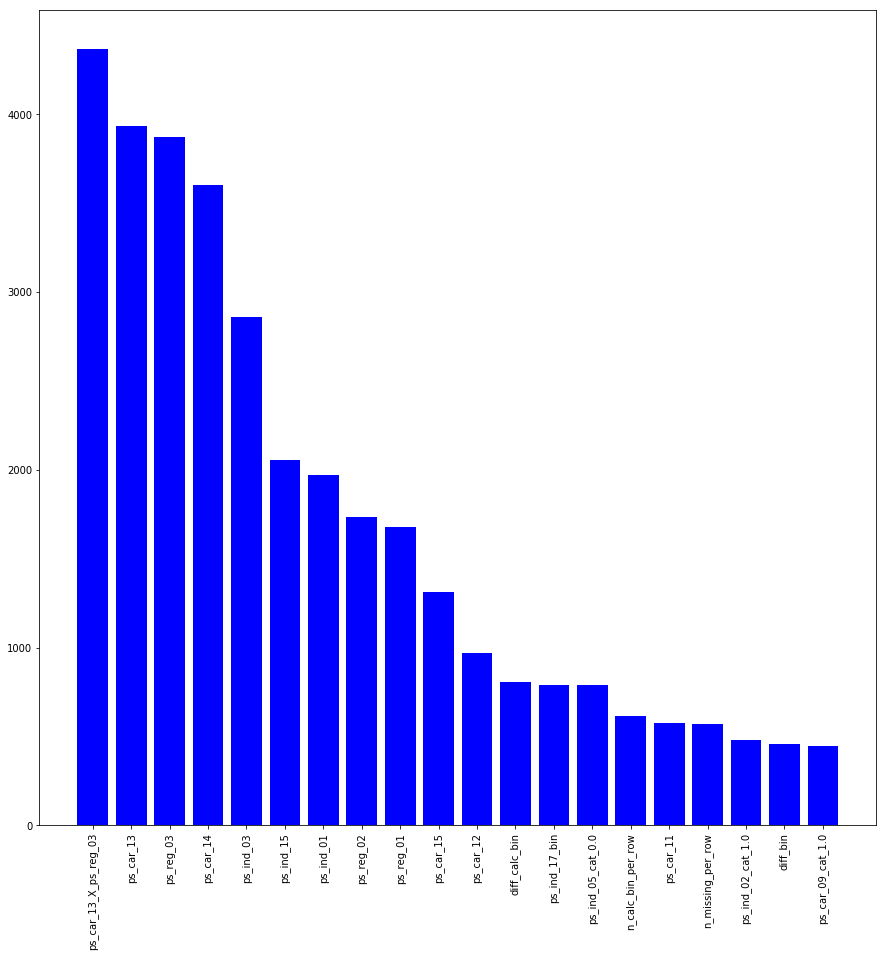

In [163]:
# Plot feature importance
max_num_features = 20
feat_imp = model.get_fscore()

feature_names = np.array([])
for name, _ in sorted(feat_imp.items(), key=lambda x:-x[1]):
    feature_names = np.append(feature_names, name)

top_features = feature_names[:max_num_features]
plt.figure(figsize=(15, 15))
plt.bar(range(max_num_features), [feat_imp[name] for name in top_features], color='b', align='center')
plt.xticks(range(max_num_features), top_features, rotation='vertical')
plt.show()